# INF-395/477 Redes Neuronales Artificiales I-2018
## Tarea 3 -  Redes Recurrentes y Autoencoders
> Juan Pablo Cruz 201473004-7

> Felipe Chacón 201303017-3

**Autoencoders (AEs) en MNIST**

2.1 Reducción de dimensionalidad

2.2 Denoising

2.3 Similarity reconstruct

2.4 Pre-training

## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen

a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [1]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
y_train = y_train[5000:]
y_val = y_train[:5000]
x_val = x_train[:5000]
x_train = x_train[5000:]
x_test = x_test.astype('float32') / 255.

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

In [0]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import matplotlib.pyplot as plt

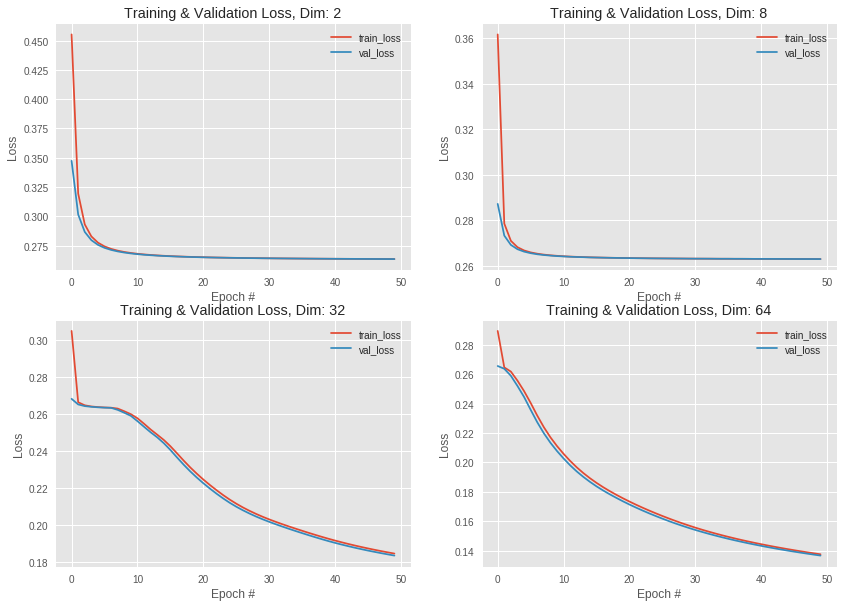

Loss con d = 2: 0.06747093796730042
Loss con d = 8: 0.06747373938560486
Loss con d = 32: 0.038735732436180115
Loss con d = 64: 0.022363703697919846


In [0]:
dims = [2, 8, 32, 64]
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
losses = []

for i,dim in enumerate(dims):
  input_img = Input(shape=(784,))
  encoded = Dense(dim, activation='sigmoid')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  encoded_input = Input(shape=(dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))

  encoded_test = encoder.predict(x_test)
  decoded_test = decoder.predict(encoded_test)
  lossAE = ((x_test - decoded_test)**2).mean()

  losses.append(lossAE)
  
  plt.subplot(2,2,i+1)
  plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
  plt.title("Training & Validation Loss, Dim: " + str(dim))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
plt.show()

print("Loss con d = 2: {}".format(losses[0]))
print("Loss con d = 8: {}".format(losses[1]))
print("Loss con d = 32: {}".format(losses[2]))
print("Loss con d = 64: {}".format(losses[3]))

* La función de pérdida de *binary_crossentropy* es mínima cuando el label que es predecido es el mismo que el real. Lo que se está prediciendo es el valor del píxel, el que se encuentra en el rango $[0,1]$ y su label indica si está siendo usado o es negro, que quiere decir que está más cercano a 1; o que no está siendo usado, siendo blanco la contraparte, o más cercano a 0.

* El porcentaje de compresión es $$(1-\frac{d}{784})*100$$ Siendo $d = [2,8,32,64]$, por lo que, respectivamente, el porcentaje de compresión es $99.74\%$, $98.98\%$, $95.92\%$ y $91.84\%$.

* El error de reconstrucción es obtenido al utilizar _mse_ de las imágenes reales con las imágenes reconstruidas, para cada $d \in {2,8,32,64}$, el error es $0.067$, $0.067$, $0.039$ y $0.022$ respectivamente. Siendo menor al comprimir menos la imagen original.

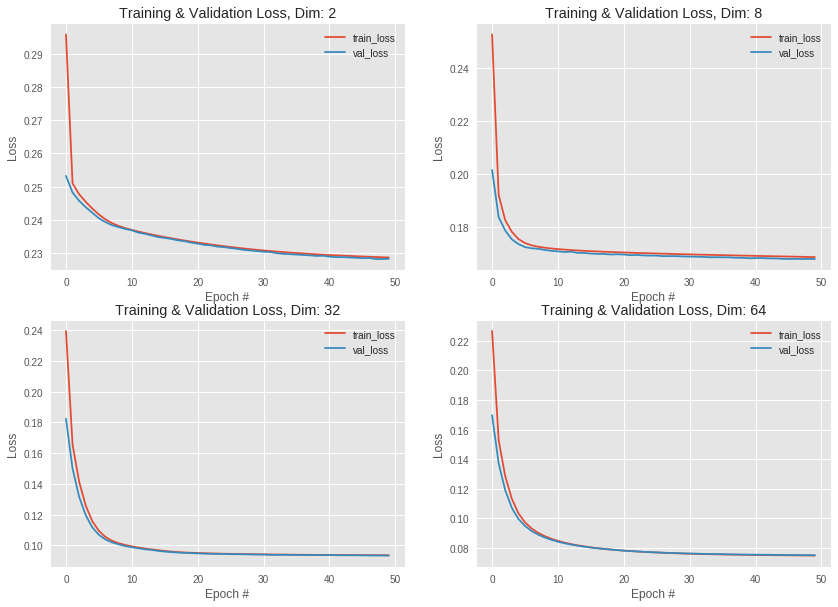

In [0]:
dims = [2, 8, 32, 64]
plt.style.use("ggplot")
plt.figure(figsize=(14,10))

for i,dim in enumerate(dims):
  input_img = Input(shape=(784,))
  encoded = Dense(dim, activation='relu')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  encoded_input = Input(shape=(dim,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))

  plt.subplot(2,2,i+1)
  plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
  plt.title("Training & Validation Loss, Dim: " + str(dim))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
plt.show()

* Una función de activacion de *ReLU* mejora el resultado del Encoder, ya que al ser todos los valores positivos, la función *sigmoid* acotaría los valores al rango $[0, 1]$, haciendo que los valores sean muy parecidos entre ellos, en cambio, *ReLu* permite tener una mejor diferenciación de los píxeles al no estar acotado superiormente. 

* Para el Decoder no corresponde utilizar *ReLU*, ya que la imagen reconstruida debe tener sus pixeles en el rango $[0,1]$, que es justamente las cotas que tiene la función *sigmoid*, en cambio, *ReLU* va desde $[0,\infty]$, por lo que se obtendrían valores fuera del rango establecido previamente.

b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.

Usando d =  2
Error de reconstrucción: 0.05643541365861893


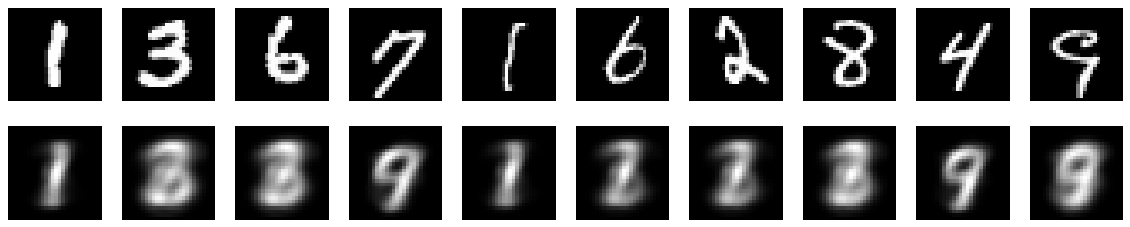

Usando d =  8
Error de reconstrucción: 0.03504372388124466


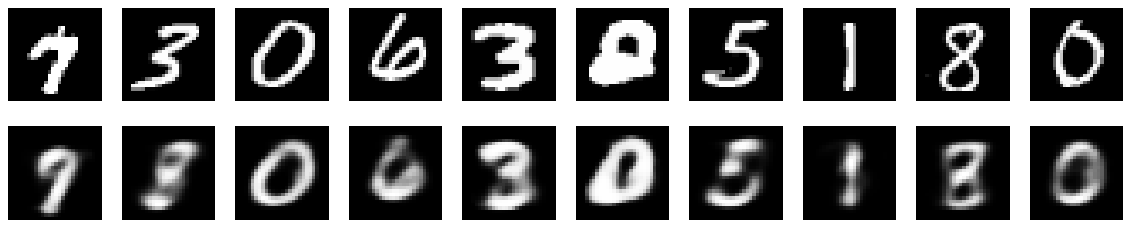

Usando d =  32
Error de reconstrucción: 0.009822591207921505


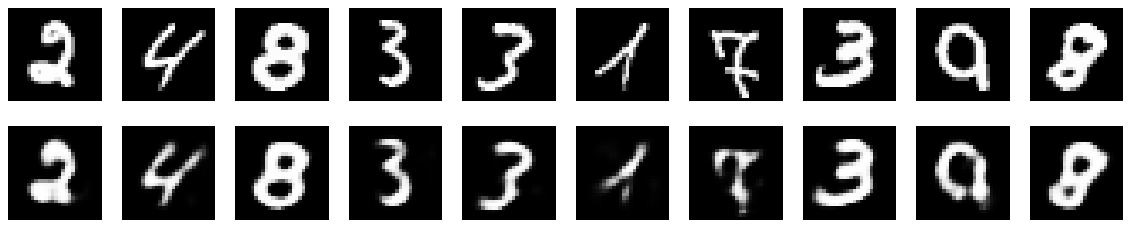

Usando d =  64
Error de reconstrucción: 0.004620012827217579


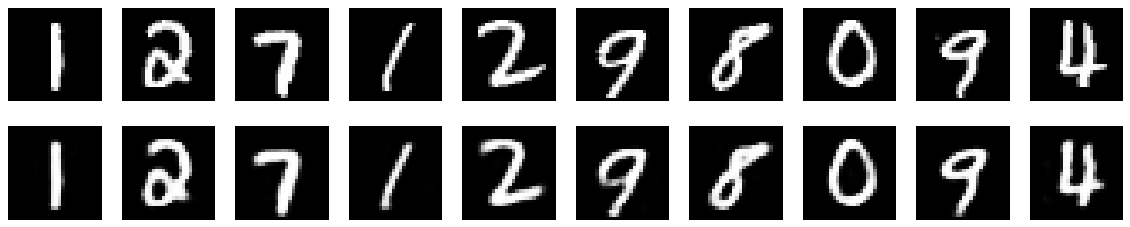

In [0]:
from keras.models import load_model
import matplotlib.pyplot as plt

dims = [2, 8, 32, 64]

for d in dims:
    input_img = Input(shape=(784,))
    encoded = Dense(d, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))

    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()
    n = 10
    plt.figure(figsize=(20, 4))
    print("Usando d = ", d)
    print("Error de reconstrucción: {}".format(lossAE))
    for i in range(n):
        j = np.random.randint(0,len(x_test))
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()    

* A mayor error de reconstrucción, el dígito es menos identificable. Utilizando un tamaño de dimensión igual a 64, se puede ver que el error es bastante bajo y, en consecuencia, la imagen reconstruida es casi idéntica a la original.
* Respecto al error de reconstrucción, hay que tener en cuenta que casi todos los dígitos se encuentran en la zona del medio de la imagen, por lo que, aunque la imagen se reconstruya mal, se tendrá un bajo error, debido a que las zonas negras alrededor de la imagen siempre coindicen y es probable que muchos píxeles blancos del medio también coincidan. Es por esto que el error siempre será bajo y debería ser analizado comparándolo con otros más que por si solo.
* De lo observado ya se puede fijar como cota máxima de error un $10\%$, en estos experimentos, el error mayor fue con $d = 2$ y dió el valor de $5.64\%$.

c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import time

dims = [2, 4, 8, 16, 64]

for d in dims:
    input_img = Input(shape=(784,))
    encoded = Dense(d, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,epochs=50, verbose = 0, batch_size=32,validation_data=(x_val,x_val))
    
    pca = PCA(n_components=d)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    x_test_projected = pca.inverse_transform(pca_test)
    lossPCA = ((x_test - x_test_projected)**2).mean()
    
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()

    print("------ Using d = {} ------".format(d))
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
    print("Loss PCA {}".format(lossPCA))
    
    begin = time.clock()
    clf.predict(pca_test)
    end = time.clock()
    print("Tiempo de predicción PCA: ", end - begin)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print('Classification Accuracy AE %.2f' % clf.score(encoded_test,y_test))
    print("Loss AE {}".format(lossAE))
    
    begin = time.clock()
    clf.predict(encoded_test)
    end = time.clock()
    print("Tiempo de predicción AE: ", end - begin)

------ Using d = 2 ------
Classification Accuracy PCA 0.44
Loss PCA 0.055664680898189545
Tiempo de predicción PCA:  0.04497500000070431
Classification Accuracy AE 0.40
Loss AE 0.056236978620290756
Tiempo de predicción AE:  0.04963599999973667
------ Using d = 4 ------
Classification Accuracy PCA 0.65
Loss PCA 0.04789749160408974
Tiempo de predicción PCA:  0.13886600000023464
Classification Accuracy AE 0.63
Loss AE 0.047345735132694244
Tiempo de predicción AE:  0.14536299999963376
------ Using d = 8 ------
Classification Accuracy PCA 0.90
Loss PCA 0.03743711858987808
Tiempo de predicción PCA:  0.9031919999997626
Classification Accuracy AE 0.90
Loss AE 0.0345369353890419
Tiempo de predicción AE:  0.7963209999998071
------ Using d = 16 ------
Classification Accuracy PCA 0.96
Loss PCA 0.026855388656258583
Tiempo de predicción PCA:  5.082718000000568
Classification Accuracy AE 0.96
Loss AE 0.021200502291321754
Tiempo de predicción AE:  5.0949030000001585
------ Using d = 64 ------
Classific

* No se observan mayores diferencias entre los resultados utilizando PCA y un Autoencoder. En ambos el accuracy es muy similar, siendo PCA mejor por muy poco.
* Los tiempos que demora cada uno en predecir son variables dependiendo del tamaño de la dimensión, pero son lo suficientemente cercanos para no poder concluir cuál es más rápido.
* En cuanto a los errores de reconstrucción, estos son muy similares entre PCA y Autoencoder. A medida que aumenta el tamaño de la dimensión, el Autoencoder empieza a reducir ligeramente su error de reconstrucción en comparación a PCA.
* Como conclusión, PCA se desempeña de forma similar a un autoencoder simple, y tiene la ventaja de que es más fácil y rápido de usar, al menos en términos de programación.
* En base a la *accuracy* obtenida por el autoencoder, se peude decir que si logra generalizar.

d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

------ Using d = 2 and L = 4 ------


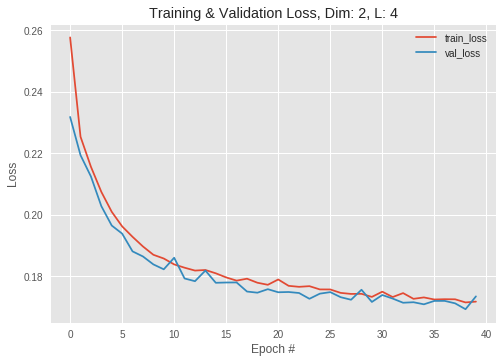

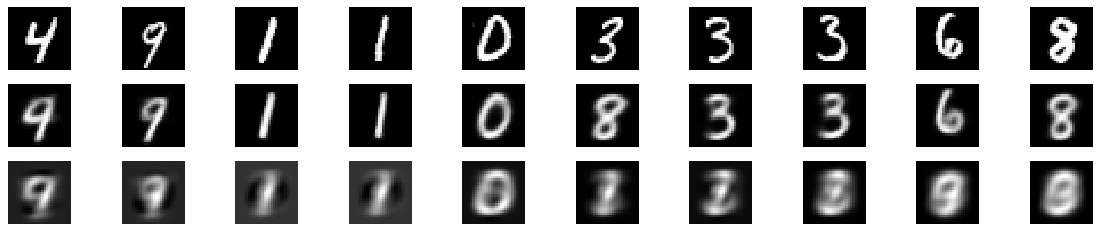

Loss PCA 0.05597850680351257
Classification Accuracy PCA 0.44
Loss AE 0.037718772888183594
Classification Accuracy AE 0.80
------ Using d = 4 and L = 4 ------


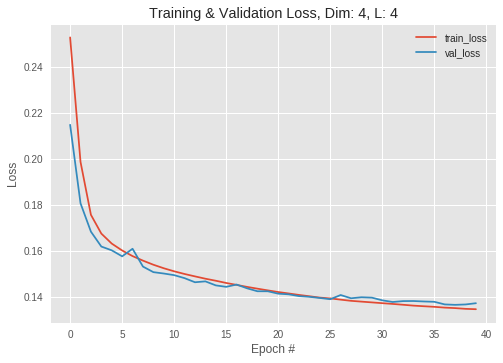

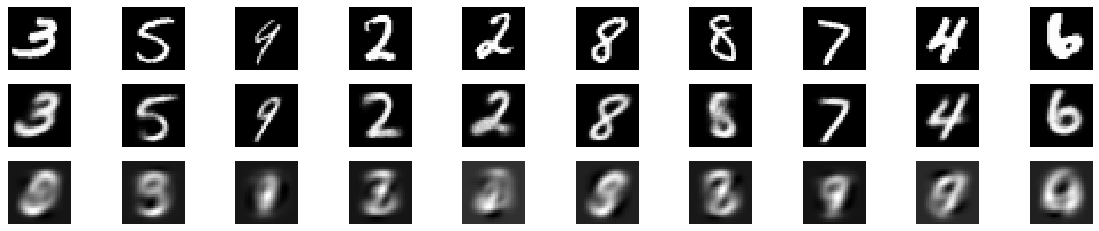

Loss PCA 0.048196207731962204
Classification Accuracy PCA 0.65
Loss AE 0.025564035400748253
Classification Accuracy AE 0.92
------ Using d = 8 and L = 3 ------


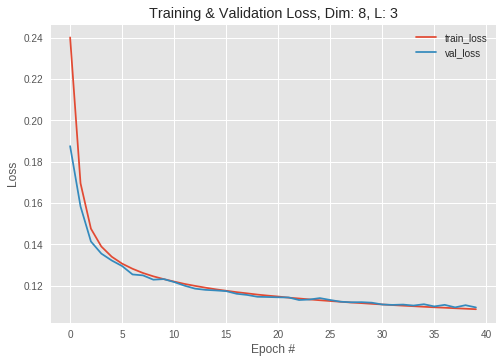

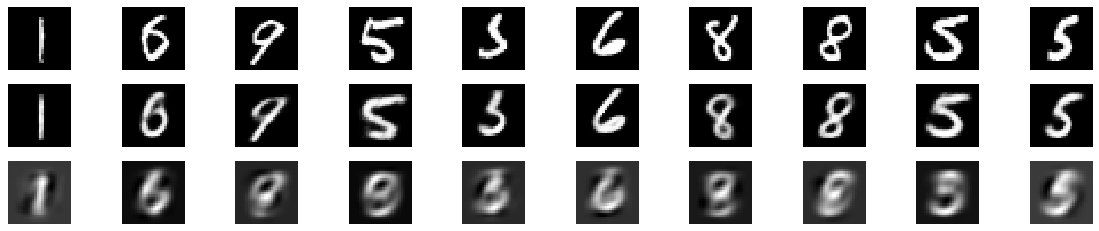

Loss PCA 0.03788596764206886
Classification Accuracy PCA 0.91
Loss AE 0.015863200649619102
Classification Accuracy AE 0.95
------ Using d = 16 and L = 3 ------


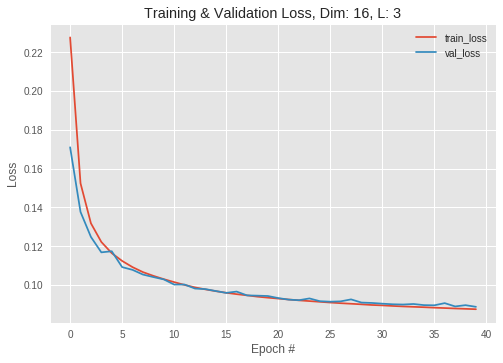

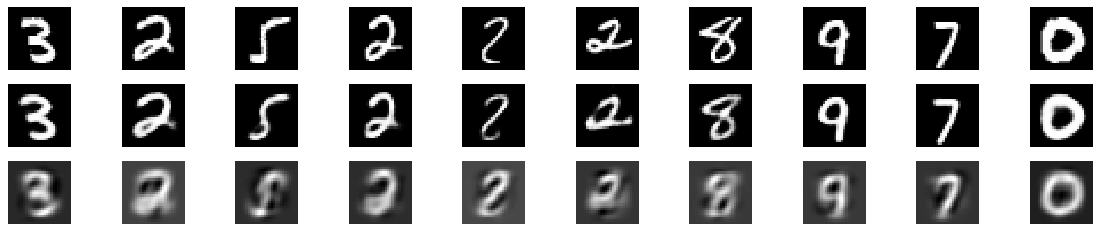

Loss PCA 0.02731345407664776
Classification Accuracy PCA 0.96
Loss AE 0.008855501189827919
Classification Accuracy AE 0.97


In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

dims = [2, 4, 8, 16]
L = [4, 4, 3, 3]

for i, dim in enumerate(dims):
    target_dim = dim
    input_img = Input(shape=(784,))
    if(i < 2):
        encoded1 = Dense(1000, activation='relu')(input_img)
        encoded2 = Dense(500, activation='relu')(encoded1)
        encoded3 = Dense(250, activation='relu')(encoded2)
        encoded4 = Dense(target_dim, activation='relu')(encoded3)
        decoded4 = Dense(250, activation='relu')(encoded4)
        decoded3 = Dense(500, activation='relu')(decoded4)
        decoded2 = Dense(1000, activation='relu')(decoded3)
        decoded1 = Dense(784, activation='sigmoid')(decoded2)
        autoencoder = Model(inputs=input_img, outputs=decoded1)        
        encoder = Model(inputs=input_img, outputs=encoded4)
        encoded_input = Input(shape=(target_dim,))
        layers = autoencoder.layers
        decoder = Model(inputs=encoded_input,
                        outputs=layers[-1](layers[-2](layers[-3](layers[-4](encoded_input)))))
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
        autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))
    else:
        encoded1 = Dense(500, activation='relu')(input_img)
        encoded2 = Dense(250, activation='relu')(encoded1)
        encoded3 = Dense(target_dim, activation='relu')(encoded2)
        decoded3 = Dense(250, activation='relu')(encoded3)
        decoded2 = Dense(500, activation='relu')(decoded3)
        decoded1 = Dense(784, activation='sigmoid')(decoded2)
        autoencoder = Model(inputs=input_img, outputs=decoded1)
        encoder = Model(inputs=input_img, outputs=encoded3)
        encoded_input = Input(shape=(target_dim,))
        layers = autoencoder.layers
        decoder = Model(inputs=encoded_input,
                        outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
        autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))
   
    pca = PCA(n_components=target_dim)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    x_projected = pca.inverse_transform(pca_train)
    loss = ((x_train - x_projected)**2).mean()
    x_projected_test = pca.inverse_transform(pca_test)
    
    print("------ Using d = {} and L = {} ------".format(dim, L[i]))
    plt.style.use("ggplot")
    plt.plot(np.arange(0, 40), autoencoder.history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 40), autoencoder.history.history["val_loss"], label="val_loss")
    plt.title("Training & Validation Loss, Dim: {}, L: {}".format(dim, L[i]))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    n = 10
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        j = np.random.randint(0,len(x_test))
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_projected_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print("Loss PCA {}".format(loss))
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
    
    print("Loss AE {}".format(lossAE))
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print('Classification Accuracy AE %.2f' % clf.score(encoded_test,y_test))

------ Using d = 2 and L = 3 ------


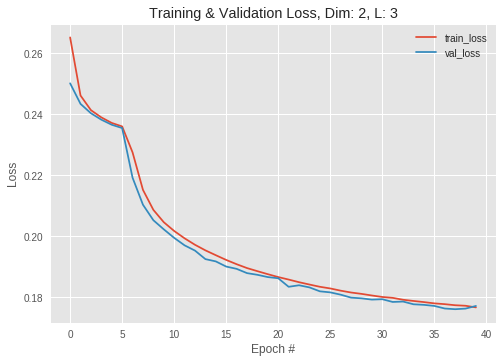

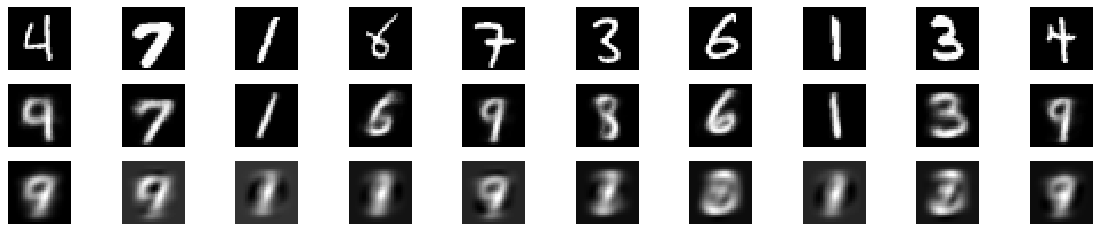

Loss PCA 0.05597851425409317
Classification Accuracy PCA 0.44
Loss AE 0.03923625871539116
Classification Accuracy AE 0.75


In [16]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

dims = [2]

for i, dim in enumerate(dims):
    target_dim = dim
    input_img = Input(shape=(784,))
    encoded1 = Dense(500, activation='relu')(input_img)
    encoded2 = Dense(250, activation='relu')(encoded1)
    encoded3 = Dense(target_dim, activation='relu')(encoded2)
    decoded3 = Dense(250, activation='relu')(encoded3)
    decoded2 = Dense(500, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(inputs=input_img, outputs=decoded1)
    encoder = Model(inputs=input_img, outputs=encoded3)
    encoded_input = Input(shape=(target_dim,))
    layers = autoencoder.layers
    decoder = Model(inputs=encoded_input,
                    outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))
   
    pca = PCA(n_components=target_dim)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    x_projected = pca.inverse_transform(pca_train)
    loss = ((x_train - x_projected)**2).mean()
    x_projected_test = pca.inverse_transform(pca_test)
    
    print("------ Using d = {} and L = {} ------".format(dim, 3))
    plt.style.use("ggplot")
    plt.plot(np.arange(0, 40), autoencoder.history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 40), autoencoder.history.history["val_loss"], label="val_loss")
    plt.title("Training & Validation Loss, Dim: {}, L: {}".format(dim, 3))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    n = 10
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        j = np.random.randint(0,len(x_test))
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_projected_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    print("Loss PCA {}".format(loss))
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
    
    print("Loss AE {}".format(lossAE))
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print('Classification Accuracy AE %.2f' % clf.score(encoded_test,y_test))

* El accuracy del autoencoder es superior en cada uno de los experimentos al de PCA, los resultados más notorios son en los que se utilizaron 4 capas para el Deep AE, ya que en estos la dimensión a la que se comprimía era considerablemente pequeña, razón por la cual PCA no tenía buenos resultados. Un ejemplo concreto es usando un tamaño de dimensión 4 y 4 capas, el Deep AE logró una accuracy de $92\%$, mientras que en PCA fue de $65\%$.
* En cuanto al tamaño de la dimensión, como era de esperarse por los experimentos previos, a mayor tamaño, mejor es la reconstrucción de la imagen. Pero al agregar más capas, es posible disminuir el tamaño de la dimensión manteniendo un buen desempeño.
* Para la cantidad de capas, se probó con $d=2$ y usando 3 y 4 capas. El desempeño con 4 capas es mejor, pero no tan distinto al de 3 capas, $0.80$ y $0.75$ de *accuracy* respectivamente.

e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.

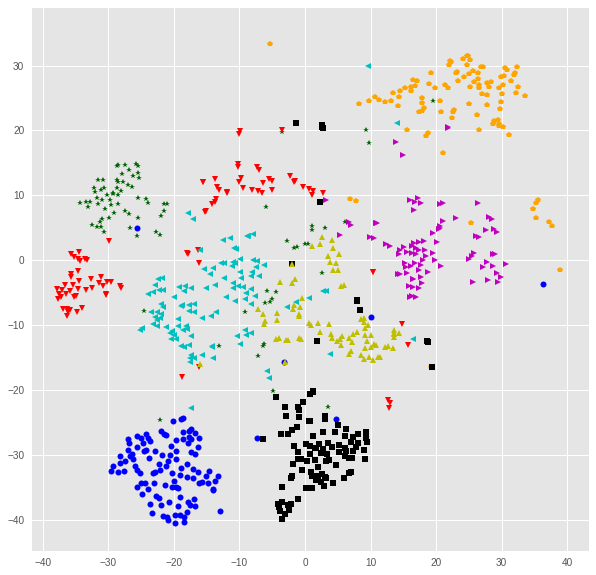

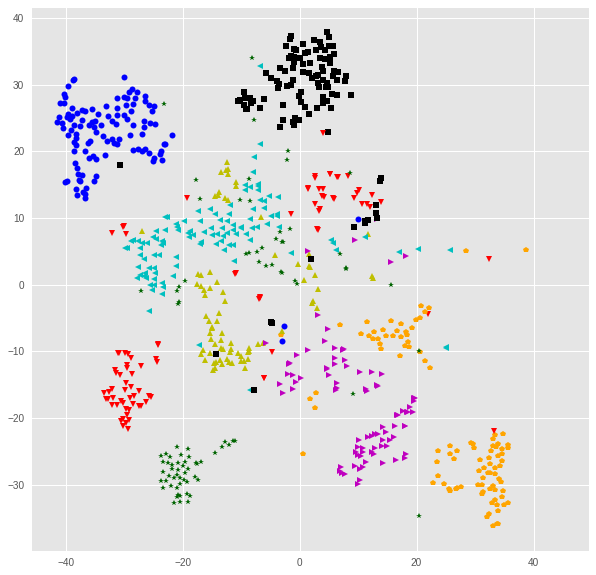

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

target_dim = 16
input_img = Input(shape=(784,))
encoded1 = Dense(500, activation='relu')(input_img)
encoded2 = Dense(250, activation='relu')(encoded1)
encoded3 = Dense(target_dim, activation='relu')(encoded2)
decoded3 = Dense(250, activation='relu')(encoded3)
decoded2 = Dense(500, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded3)
encoded_input = Input(shape=(target_dim,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input,
                outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))

nplot=1000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

pca = PCA(n_components=target_dim)
pca.fit(x_train)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

* No se ven mayores diferencias entre las representaciones del autoencoder con las de PCA, pero esto es debido a la dimensión elegida de $16$, como se ve en la pregunta anterior, el *accuracy* de PCA y del Autoencoder con 3 capas ocultas es similar, $0.96$ y $0.97$ respectivamente.
* Utilizando $d = 4$ y $4$ capas para el autoencoder, se espera que sea más notoria la diferencia, pues con estos parámetros se obtuvo una *accuracy* de $0.65$ para PCA y de $0.92$ para el autoencoder.

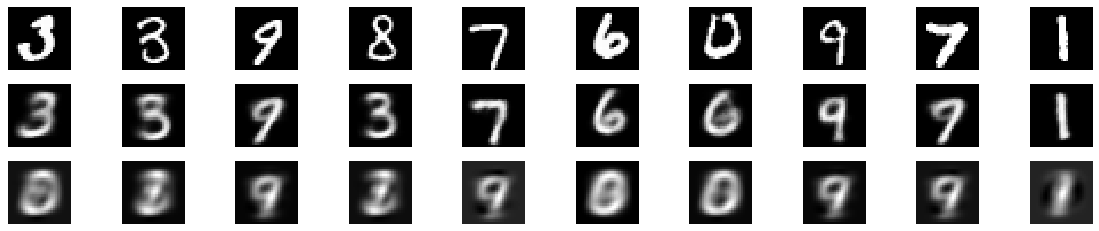

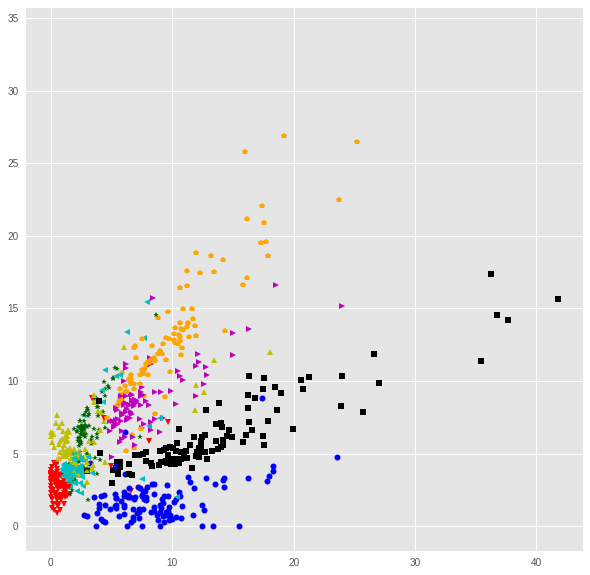

In [0]:
target_dim = 2
input_img = Input(shape=(784,))
encoded1 = Dense(500, activation='relu')(input_img)
encoded2 = Dense(250, activation='relu')(encoded1)
encoded3 = Dense(target_dim, activation='relu')(encoded2)
decoded3 = Dense(250, activation='relu')(encoded3)
decoded2 = Dense(500, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded3)
encoded_input = Input(shape=(target_dim,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input,
                outputs=layers[-1](layers[-2](layers[-3]((encoded_input)))))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train, verbose = 0, epochs=40, batch_size=32,validation_data=(x_val,x_val))

n = 10
pca = PCA(n_components=target_dim)
pca.fit(x_train)
pca_test = pca.transform(x_test)
x_projected_test = pca.inverse_transform(pca_test)
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_projected_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

encoded_train = encoder.predict(x_train[:nplot]) #Autoencoder with d=2
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

* El autoencoder con $d=2$ logra separar la mayoría de las clases, pero estas se encuentran bastante juntas entre si, por lo que es esperable tener errores como los que se pueden observar en la fila de dígitos del medio.

f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

In [0]:
from keras.layers import *

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
input_img = Input(shape=(28, 28, 1))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 16)        0         
__________

* La cantidad de parámetros es considerablemente menor.


### 2.2 Denoising
Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
y_train = y_train[5000:]
y_val = y_train[:5000]
x_val = x_train[:5000]
x_train = x_train[5000:]
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [0]:
from numpy.random import binomial

noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

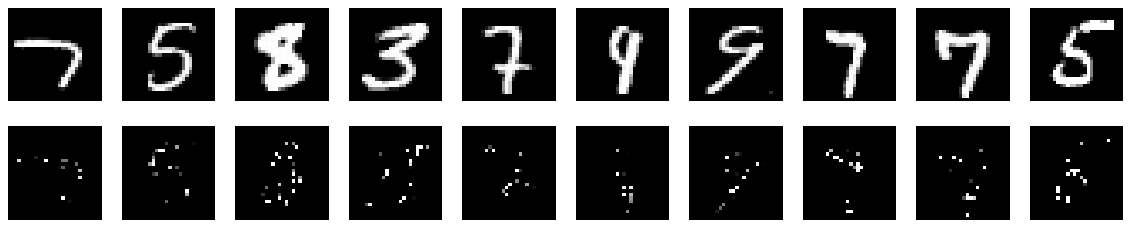

In [0]:
plt.figure(figsize=(20, 4))
n = 10
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**

------ Using noisy level = 0.1 ------


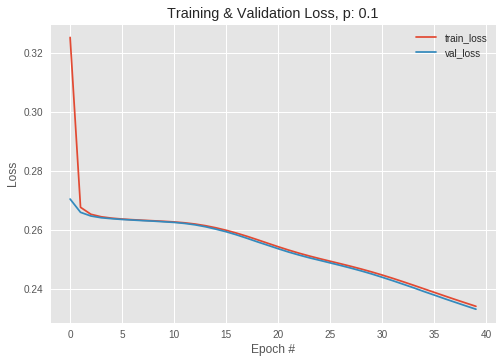

Loss AE 0.05644340068101883


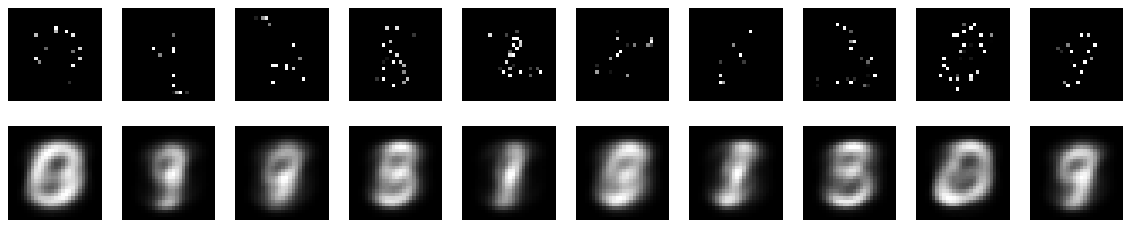

------ Using noisy level = 0.3 ------


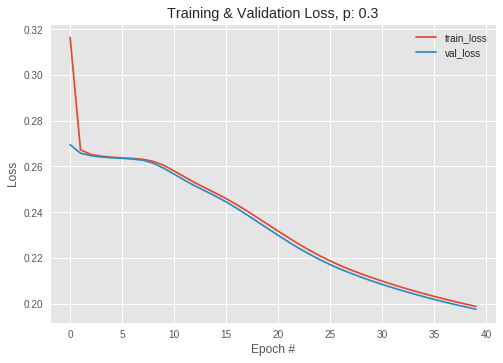

Loss AE 0.0440555103123188


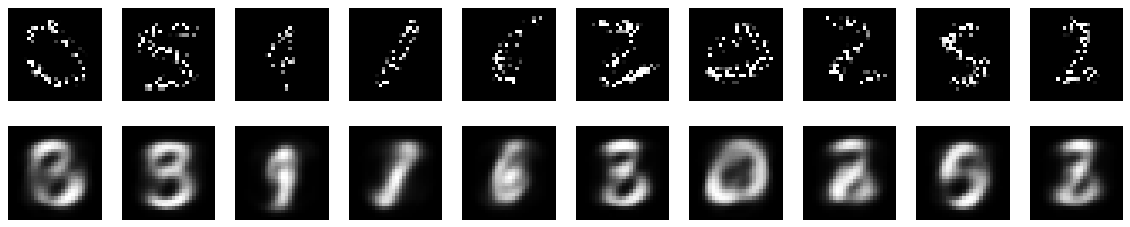

------ Using noisy level = 0.5 ------


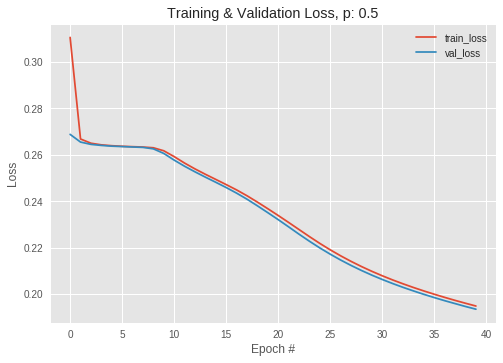

Loss AE 0.04236364737153053


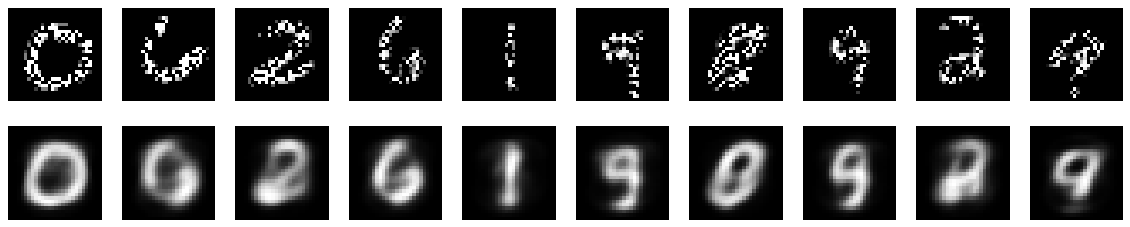

------ Using noisy level = 0.8 ------


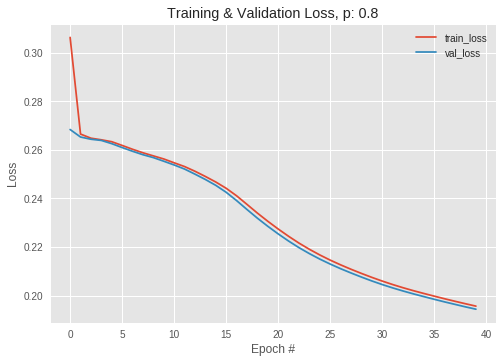

Loss AE 0.042581427842378616


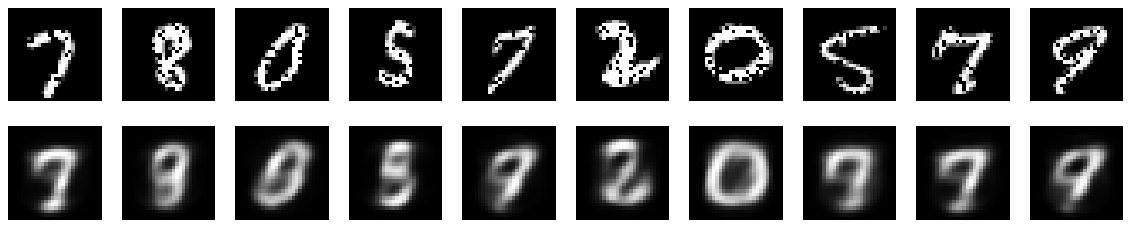

In [0]:
from numpy.random import binomial

ps = [0.1, 0.3, 0.5, 0.8]

for p in ps:
    noise_level = p
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask

    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train, x_train, verbose=0, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))
    
    print("------ Using noisy level = {} ------".format(p))
    plt.style.use("ggplot")
    plt.plot(np.arange(0, 40), autoencoder.history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 40), autoencoder.history.history["val_loss"], label="val_loss")
    plt.title("Training & Validation Loss, p: {}".format(p))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    lossAE = ((x_test - decoded_test)**2).mean()
    
    print("Loss AE {}".format(lossAE))
    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        j = np.random.randint(0,len(x_test))
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

* Para el ojo humano, según los experimentos, desde un _noisy level_ de 0.3 se distingue vagamente el dígito de la imagen. Sin embargo, el autoencoder es capaz de reconstruir algunos dígitos. Ya con 0.5 el autoencoder se desempeña de mejor manera, con los ocasionales error como por ejemplo confundir los 4 con los 9.

c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.

In [0]:
noise_level = 0.5
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(noisy_x_train, x_train, verbose=0, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))

encoded_train = encoder.predict(noisy_x_train)
encoded_test = encoder.predict(noisy_x_test)
decoded_test = decoder.predict(encoded_test)

clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print('Classification Accuracy denoising AE %.2f' % clf.score(encoded_test,y_test))

Classification Accuracy denoising AE 0.79


* Al utilizar un valor de ruido de 0.5, la accuracy del autoencoder no es mala, pero no logra a desempeñarse de la misma forma que utilizando imágenes sin ruido. Se necesita una mejor implementación para alcanzar un mayor accuracy y reconstruir de mejor forma las imágenes.

d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

In [0]:
import cv2

def corruptImages(imgs):
    imgs = np.asarray(list(map(lambda x: cv2.GaussianBlur(x, ksize=(9,9), sigmaX=1), imgs)))
    imgs = np.asarray(list(map(lambda x: cv2.GaussianBlur(x, ksize=(3,3), sigmaX=0), imgs)))
    imgs = np.asarray(list(map(lambda x: cv2.morphologyEx(x, cv2.MORPH_GRADIENT, kernel=(5,5)), imgs)))
    return imgs

* Para corromper las imágenes, se utilizó un filtro Gaussiano que suaviza la imagen haciendo que se pierdan detalles. Esto se realizó 2 veces con distintos tamaños del filto. Luego, se realiza una operación morfológica que solo deja los bordes de los dígitos, dejando las imágenes mayormente negras.

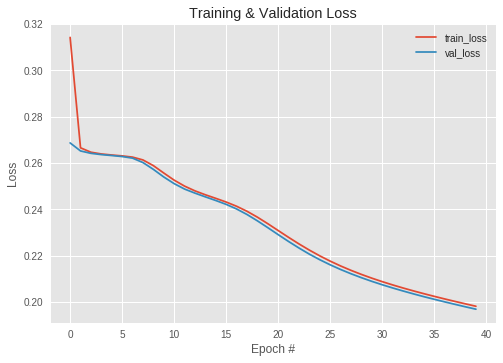

Loss AE 0.044510506093502045


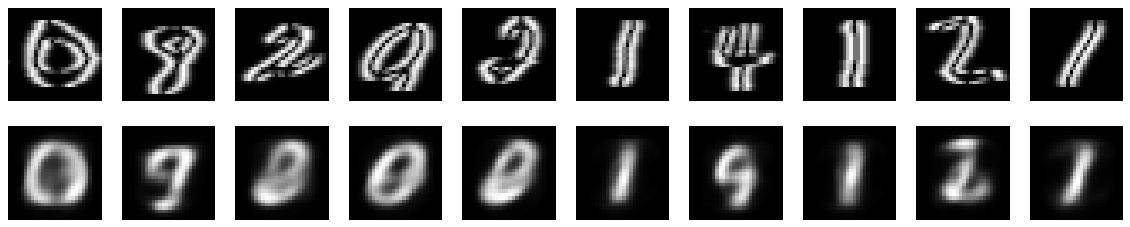

In [0]:
corrupted_x_train = corruptImages(x_train).reshape((len(x_train),784))
corrupted_x_val = corruptImages(x_val).reshape((len(x_val),784))
corrupted_x_test = corruptImages(x_test).reshape((len(x_test),784))

input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(corrupted_x_train, x_train, verbose=0, epochs=40, batch_size=32, validation_data=(corrupted_x_val, x_val))

plt.style.use("ggplot")
plt.plot(np.arange(0, 40), autoencoder.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), autoencoder.history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

encoded_test = encoder.predict(corrupted_x_test)
decoded_test = decoder.predict(encoded_test)
lossAE = ((x_test - decoded_test)**2).mean()

print("Loss AE {}".format(lossAE))

encoded_test = encoder.predict(corrupted_x_test)
decoded_test = decoder.predict(encoded_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(corrupted_x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

* La reconstrucción de la imagen falla en la mayoría de las clases, siendo el dígito 1 el mejor reconstruido en base al experimento anterior.
* Para el error de reconstrucción se constrasta la imagen original, sin corromper, junto con la reconstrucción generada por el encoder. El error no es bastante alto para este contexto, lo que corresponde a las imágenes de ejemplo mostradas.

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.

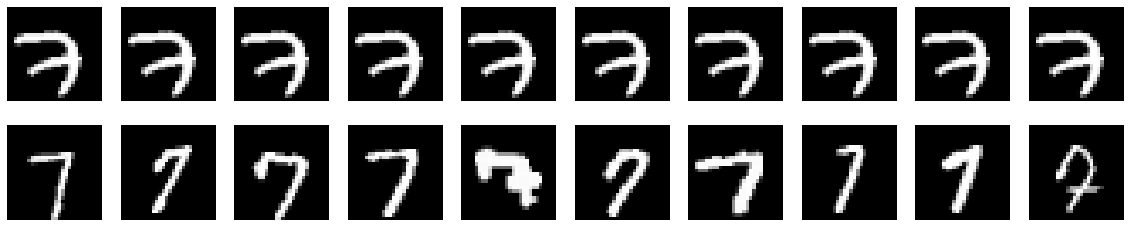

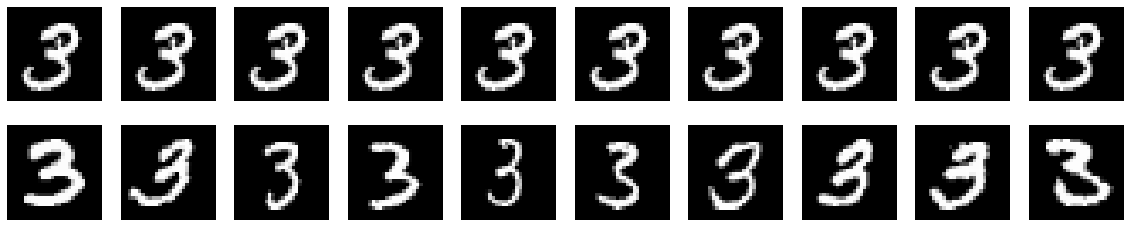

In [4]:
def similarity_data(X,Y,sim=10):
    index_classes = [ np.where(Y==number)[0] for number in range(10)]
    new_X = np.zeros((1,X.shape[1]))
    simi_X = np.zeros((1,X.shape[1]))
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X = np.concatenate((new_X, np.tile(x,(sim,1))),axis=0)
        simi_X = np.concatenate((simi_X, X[sample_sim]),axis=0)
    return new_X[1:],simi_X[1:]
data, data_sim = similarity_data(x_train[:2000],y_train[:2000])

n = 10
j = -1
for k in range(2):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j += 1
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(data[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(data_sim[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

* Las primeras 10 imágenes de _data_ corresponden a exactamente la misma imagen, pero las 10 imágenes de *data_sim* muestra imágenes distintas y de la misma clase.

b) Escoga algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**

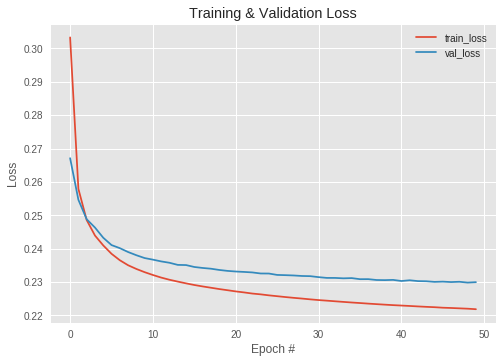

Loss AE 0.04984265938401222


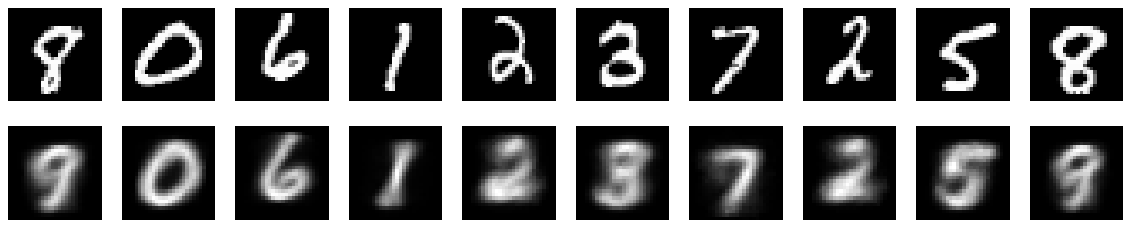

In [8]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoded_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoded_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(data,data_sim,verbose=0,epochs=50,batch_size=32,validation_split=0.2)

plt.style.use("ggplot")
plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)

lossAE = ((x_test - decoded_test)**2).mean()
print("Loss AE {}".format(lossAE))

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

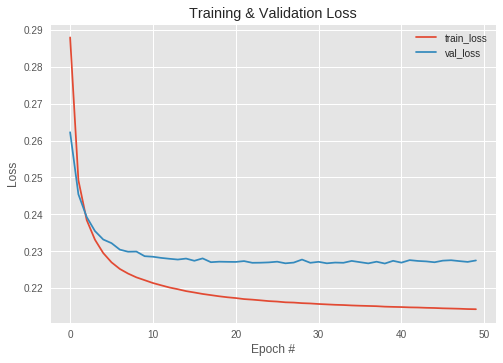

Loss AE 0.051990218460559845


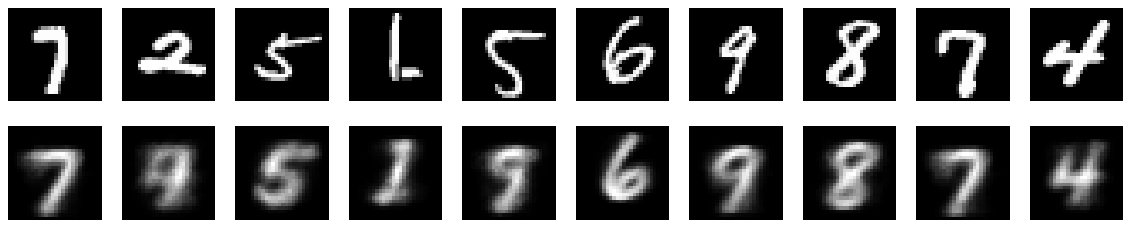

In [6]:
input_img = Input(shape=(784,))
encoded1 = Dense(250, activation='relu')(input_img)
encoded2 = Dense(32, activation='relu')(encoded1)
decoded2 = Dense(250, activation='relu')(encoded2)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded2)
encoded_input = Input(shape=(32,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input, outputs=layers[-1](layers[-2](encoded_input)))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(data,data_sim,verbose=0,epochs=50,batch_size=32,validation_split=0.2)

plt.style.use("ggplot")
plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)

lossAE = ((x_test - decoded_test)**2).mean()
print("Loss AE {}".format(lossAE))

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

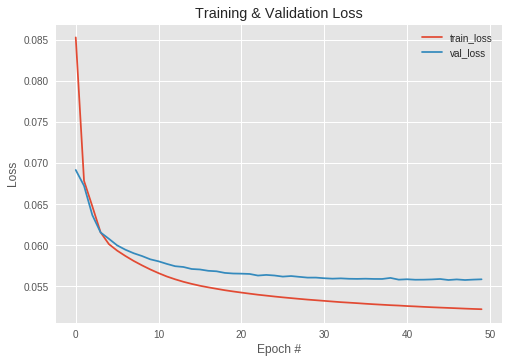

Loss AE 0.051441386342048645


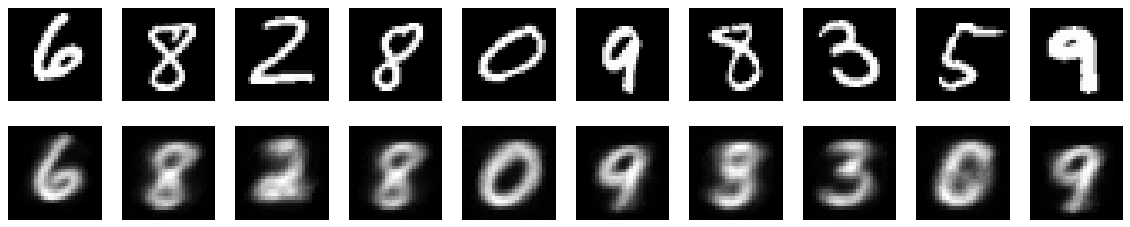

In [7]:
input_img = Input(shape=(784,))
encoded1 = Dense(250, activation='relu')(input_img)
encoded2 = Dense(32, activation='relu')(encoded1)
decoded2 = Dense(250, activation='relu')(encoded2)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded2)
encoded_input = Input(shape=(32,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input, outputs=layers[-1](layers[-2](encoded_input)))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error')
autoencoder.fit(data,data_sim,verbose=0,epochs=50,batch_size=32,validation_split=0.2)

plt.style.use("ggplot")
plt.plot(np.arange(0, 50), autoencoder.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), autoencoder.history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)

lossAE = ((x_test - decoded_test)**2).mean()
print("Loss AE {}".format(lossAE))

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

* Un autoencoder *shallow* entrega resultados visuales aceptables, es posible distinguir los dígitos en las imágenes.
* Utilizando otra capa y manteniendo la función de pérdida *binary crossentropy*, los resultados se mantienen en comparación a la arquitectura anterior.
* Utilizando *mean squared error* como función de pérdida se observa un desempeño muy similar al anterior. La mejora del error de reconstrucción es despreciable.

* Se puede concluir que no es necesario cambiar la función de pérdida.

c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.

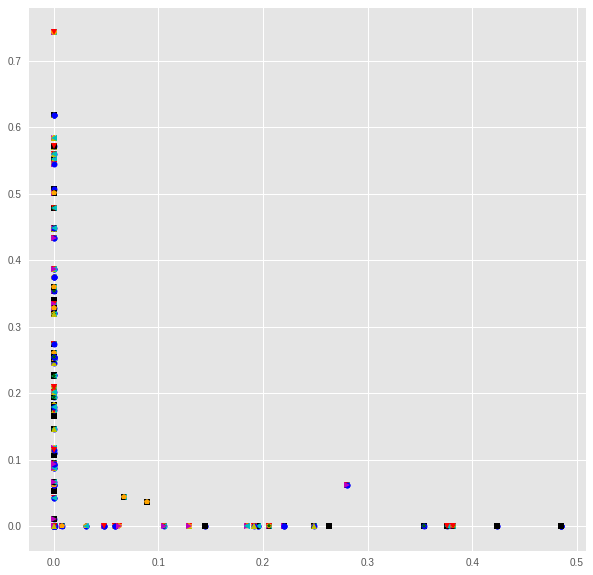

In [10]:
from sklearn.manifold import TSNE

input_img = Input(shape=(784,))
encoded1 = Dense(250, activation='relu')(input_img)
encoded2 = Dense(32, activation='relu')(encoded1)
decoded2 = Dense(250, activation='relu')(encoded2)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(inputs=input_img, outputs=decoded1)
encoder = Model(inputs=input_img, outputs=encoded2)
encoded_input = Input(shape=(32,))
layers = autoencoder.layers
decoder = Model(inputs=encoded_input, outputs=layers[-1](layers[-2](encoded_input)))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(data,data_sim,verbose=0,epochs=50,batch_size=32,validation_split=0.2)

nplot=2000 #warning: mind your memory!

autoencoder.predict(data)
embeddings = encoder.predict(data)

model = TSNE(n_components=2, random_state=0)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(embeddings[idx][0], embeddings[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $784 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**

In [0]:
from keras.utils import to_categorical
Y_train = to_categorical(y_train, 10)
Y_val = to_categorical(y_val, 10)
Y_test = to_categorical(y_test, 10)
from keras.models import Sequential
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train ,verbose = 0, epochs=50, batch_size=32,shuffle=True, validation_data=(x_val, Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_118 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_119 (Dense)            (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


In [0]:
loss, acc = model.evaluate(x_test, Y_test, verbose=0)
print("El error de clasificación es de {}".format(loss))
print("El accuracy fue de {}".format(acc))

El error de clasificación es de 0.07920345958927646
El accuracy fue de 0.976


b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.

In [0]:
n_hidden_layer1 = 1000
n_hidden_layer2 = 1000
optimizer_ = SGD(lr=0.01, momentum=0.9)
activation_layer1 = "relu"
activation_layer2 = "relu"
decoder_activation_1 = "sigmoid"
decoder_activation_2 = "sigmoid"
loss_ = "binary_crossentropy"
batch_size_ = 32
epochs_ = 40

In [0]:
from keras.datasets import mnist
## Load and preprocess MNIST as usual

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, verbose = 0, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1, verbose = 0, epochs=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=20, verbose = 0, batch_size=32, shuffle=True, validation_data=(x_val, Y_val))

In [0]:
loss, acc = model.evaluate(x_test, Y_test, verbose=0)
print("El error de clasificación es de {}".format(loss))
print("El accuracy fue de {}".format(acc))

El error de clasificación es de 14.535298237609863
El accuracy fue de 0.0982


In [14]:
n_hidden_layer1 = 1000
n_hidden_layer2 = 1000
optimizer_ = SGD(lr=0.01, momentum=0.9)
activation_layer1 = "sigmoid"
activation_layer2 = "sigmoid"
decoder_activation_1 = "sigmoid"
decoder_activation_2 = "sigmoid"
loss_ = "binary_crossentropy"
batch_size_ = 32
epochs_ = 40

from keras.datasets import mnist
## Load and preprocess MNIST as usual

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, verbose = 0, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1, verbose = 0, epochs=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=20, verbose = 0, batch_size=32, shuffle=True, validation_data=(x_val, Y_val))

loss, acc = model.evaluate(x_test, Y_test, verbose=0)
print("El error de clasificación es de {}".format(loss))
print("El accuracy fue de {}".format(acc))

El error de clasificación es de 0.09746377518717199
El accuracy fue de 0.9697


* El desempeño de la red mejora considerablemente si se utilizando solo funciones de activación *sigmoid*, pasó de un *accuracy* de $0.10$ a $0.97$.

c) Repita usando funciones de **activación *tanh*. Comente**

In [0]:
n_hidden_layer1 = 1000
n_hidden_layer2 = 1000
optimizer_ = SGD(lr=0.01, momentum=0.9)
activation_layer1 = "tanh"
activation_layer2 = "tanh"
decoder_activation_1 = "tanh"
decoder_activation_2 = "tanh"
loss_ = "binary_crossentropy"
batch_size_ = 32
epochs_ = 40

In [0]:
from keras.datasets import mnist
## Load and preprocess MNIST as usual

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=epochs_, verbose = 0, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,epochs=epochs_, verbose = 0, batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train, epochs=20, batch_size=32, verbose = 0, shuffle=True, validation_data=(x_val, Y_val))

In [0]:
loss, acc = model.evaluate(x_test, Y_test, verbose=0)
print("El error de clasificación es de {}".format(loss))
print("El accuracy fue de {}".format(acc))

El error de clasificación es de 0.11010551452157451
El accuracy fue de 0.9745


* El resultado es completamente distinto a la arquitectura anterior que utilizó *ReLUs*, se logra una buena accuracy y el error de clasificación es bajo.
* Respecto a la red que utiliza funciones *sigmoid*, el desempeño es similar, pero sigue siendo mejor por un poco esta última usando *tanh*.

## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.